In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import scipy.stats

from ssm import HMM
import matplotlib.pyplot as plt

%matplotlib inline

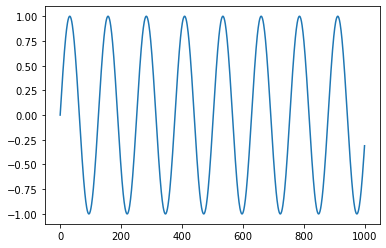

In [3]:
T = 1000
M = 10    # number of input dimensions

# simulate position
x = np.sin(np.arange(T) / 20)

plt.plot(x)

-1.0 0.2
-0.7777777777777778 0.2
-0.5555555555555556 0.2
-0.33333333333333337 0.2
-0.11111111111111116 0.2
0.11111111111111116 0.2
0.33333333333333326 0.2
0.5555555555555556 0.2
0.7777777777777777 0.2
1.0 0.2


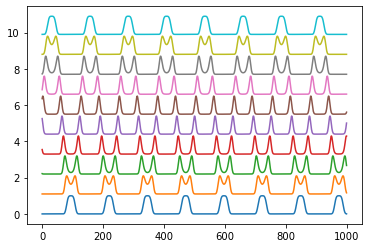

In [4]:
# Encode position with Gaussian pdfs
X = np.zeros((T, M))
for m in range(M):
    mu = -1 + 2 * m / (M-1)
    sigma = 2 / M
    print(mu, sigma)
    X[:, m] = scipy.stats.norm(mu, sigma).pdf(x)
    
X /= X.max()
    
plt.plot(X + 1.1 * np.arange(M))

In [11]:
# Sample a Poisson GLM with these inputs
K = 2     # number of discrete states
N = 100   # number of neurons

hmm = HMM(K, N, M=M, 
          observations="poisson_glm", 
          observation_kwargs=dict(mean_function="softplus"))

# hmm.observations.W[0, N//2:] = 0
# hmm.observations.W[1, :N//2] = 0

P = 0.99 * np.eye(K) + 0.01 * (1 - np.eye(K))
hmm.transitions.log_Ps = np.log(P)

In [12]:
z, y = hmm.sample(T, input=X)

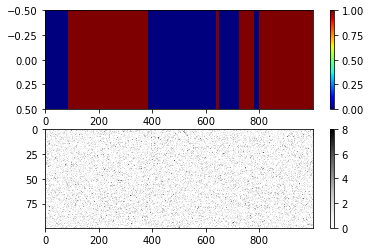

In [13]:
plt.figure()
plt.subplot(211)
plt.imshow(z[None, :], aspect="auto", cmap="jet")
plt.colorbar()

plt.subplot(212)
plt.imshow(y.T, aspect="auto", cmap="Greys")
plt.colorbar()

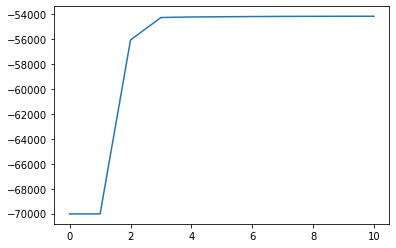

In [9]:
test_hmm = HMM(K, N, M=M, 
               observations="poisson_glm", 
               observation_kwargs=dict(mean_function="softplus"))

lls = test_hmm.fit(y, inputs=X, num_em_iters=10)

plt.plot(lls)

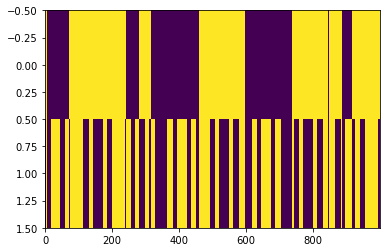

In [10]:
zhat = test_hmm.most_likely_states(y, input=X)
plt.imshow(np.row_stack((z, zhat)), aspect="auto")